# `ABOUT THE PROJECT`

This project focuses on developing a model to predict whether two questions are duplicates using a dataset containing question pairs and corresponding labels. The process involves loading and exploring the data, handling missing values, and preprocessing the text through normalization and cleaning. Feature engineering is employed to create both basic and advanced features, such as question length, word counts, common words, and fuzzy matching scores. Machine learning models, including Random Forest and XGBoost, are trained on these features to classify duplicate questions, with performance evaluated through accuracy scores and confusion matrices. Visualization techniques are used to understand feature relationships, and a prediction pipeline is established to preprocess and predict duplicate status for new question pairs. This comprehensive approach aims to enhance the identification of redundant content in Q&A forums.

## `Importing the required Libraries`

In [82]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import re
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from fuzzywuzzy import fuzz
import distance  
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## `Loading the dataset`

In [2]:
df = pd.read_csv('questions.csv')
df.sample(10)

,id,qid1,qid2,question1,question2,is_duplicate
160355,160355,317057,81391,Why should two lovers get married?,Why do people get married?,1
249595,249595,491431,491432,What are your views on banning 500 and 1000 ru...,What do you think about banning 500 and 1000 r...,1
42471,42471,84589,84590,Can I use Jio sim in 3G smartphone?,How can I use Jio sim in 3G Micromax A102?,1
273327,273327,537502,537503,"Would Indian men prefer a cute woman or a hot,...",What are some of the misconceptions you have w...,0
276530,276530,543709,543710,How can one learn to love life?,How can you learn to love life?,1
107868,107868,213928,213929,What is the Swiss challenge?,How can I get a Swiss passport?,0
19542,19542,38996,38997,What is the answer of 7+7/7+7*7-7=?,What is the answer for 7+7/7+7*7-7=?,1
209119,209119,412509,412510,Why do we indians stare a lot?,Why do we Indians stare so much?,1
4238,4238,8474,8475,Which are the top civil services coaching inst...,Which are the best civil services coaching ins...,1
162084,162084,320449,320450,How do you play disc golf competitively?,What are some tips for playing disc golf?,0


## `EDA`

In [3]:
df.shape

(404351, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404350 non-null  object
 4   question2     404349 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
# Checking null values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
# Duplicated values
df.duplicated().sum()

0

In [7]:
# Checking how many questions are duplicated and how many are not
df['is_duplicate'].value_counts()

0    255045
1    149306
Name: is_duplicate, dtype: int64

<AxesSubplot:>

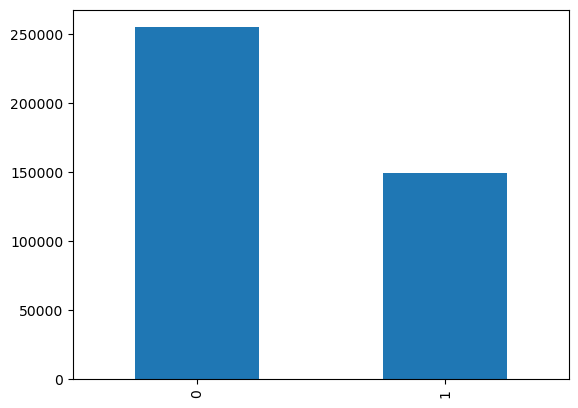

In [8]:
df['is_duplicate'].value_counts().plot(kind='bar')

In [9]:
# Repeated questions

qid = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print('Number of unique questions',np.unique(qid).shape[0])
x = qid.value_counts()>1
print('Number of questions getting repeated',x[x].shape[0])

Number of unique questions 789801
Number of questions getting repeated 13698


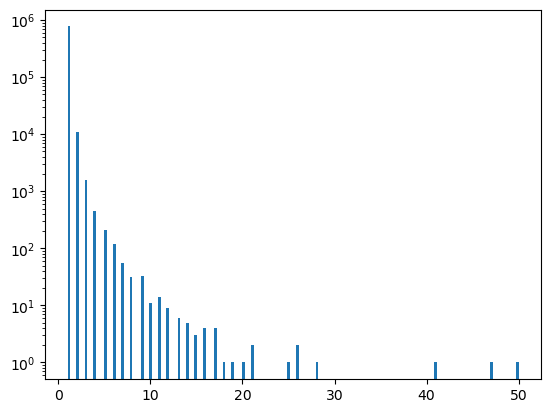

In [10]:
# Repeated questions histogram

plt.hist(qid.value_counts().values , bins=160)
plt.yscale('log')
plt.show()

# `MODEL TRAINING`

## `1. BOW By Using Basic Features`

In this feature engineering step, the code samples 20,000 rows from the original DataFrame and checks for null values. It extracts the questions, converts them into numerical feature vectors using a `CountVectorizer` limited to the 3000 most frequent words, and splits these vectors into separate arrays for the first and second questions. These arrays are then concatenated into a single DataFrame, which is augmented with a target column indicating if the pairs are duplicates. The data is split into training and testing sets, and two machine learning models, a `RandomForestClassifier` and an `XGBClassifier`, are trained and evaluated on this data. The accuracy of both models is calculated to compare their performance.

In [11]:
new_df = df.sample(20000,random_state=2)

In [12]:
new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [13]:
ques_df = new_df[['question1' , 'question2']]

In [14]:
questions = list(ques_df['question1']) + list(ques_df['question2'])

In [15]:
cv = CountVectorizer(max_features=3000)

q1_arr , q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

Above code processes a list of paired questions by converting them into numerical feature vectors using the 3000 most frequent words, then splits these vectors into two arrays for further analysis or model training.

In [16]:
temp1 = pd.DataFrame(q1_arr , index=ques_df.index)
temp2 = pd.DataFrame(q2_arr , index=ques_df.index)
temp_df = pd.concat([temp1 , temp2] , axis=1)
temp_df.shape

(20000, 6000)

In [17]:
temp_df['is_duplicate'] = new_df['is_duplicate']

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(temp_df.iloc[: , 0:-1].values , new_df.iloc[: , -1].values , random_state=2 , test_size=0.2)

In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [21]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7375

In [23]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

0.72

## `2. BOW With Preprocessing & Advanced Features`

To improve the model's accuracy, preprocessing steps such as lower-casing, replacing certain special characters, decontracting words, and removing HTML tags and punctuation etc were performed. Advanced features were introduced, and their relationships and effects on the dataset were visualized. Finally, the model was trained using a Random Forest Classifier and XGBoost to evaluate the accuracy.

In [24]:
new_df = df.sample(20000,random_state=2)

,id,qid1,qid2,question1,question2,is_duplicate
339499,339499,665522,665523,Why was Cyrus Mistry removed as the Chairman o...,Why did the Tata Sons sacked Cyrus Mistry?,1
289521,289521,568878,568879,By what age would you think a man should be ma...,When my wrist is extended I feel a shock and b...,0
4665,4665,9325,9326,How would an arbitrageur seek to capitalize gi...,How would an arbitrageur seek to capitalize gi...,0
54203,54203,107861,107862,Why did Quora mark my question as incomplete?,Why does Quora detect my question as an incomp...,1
132566,132566,262554,91499,What is it like working with Pivotal Labs as a...,What's it like to work at Pivotal Labs?,0


In [25]:
def preprocess(q):
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalent
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar')    
    q = q.replace('₹', ' rupee')    
    q = q.replace('€', ' euro')    
    q = q.replace('@', ' at')    

    # The pattern '[math]' appear around 900 times in the whole dataset
    q = q.replace('[math]', '')
    
    # Replace some number with string equivalents 
    q = q.replace(',000,000,000', 'b ')
    q = q.replace(',000,000', 'm ')    
    q = q.replace(',000', 'k ')    
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)0000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    contractions = { 
        "ain't": "am not / are not / is not / has not / have not",
        "aren't": "are not / am not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he had / he would",
        "he'd've": "he would have",
        "he'll": "he shall / he will",
        "he'll've": "he shall have / he will have",
        "he's": "he has / he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how has / how is / how does",
        "I'd": "I had / I would",
        "I'd've": "I would have",
        "I'll": "I shall / I will",
        "I'll've": "I shall have / I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it had / it would",
        "it'd've": "it would have",
        "it'll": "it shall / it will",
        "it'll've": "it shall have / it will have",
        "it's": "it has / it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she had / she would",
        "she'd've": "she would have",
        "she'll": "she shall / she will",
        "she'll've": "she shall have / she will have",
        "she's": "she has / she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as / so is",
        "that'd": "that would / that had",
        "that'd've": "that would have",
        "that's": "that has / that is",
        "there'd": "there had / there would",
        "there'd've": "there would have",
        "there's": "there has / there is",
        "they'd": "they had / they would",
        "they'd've": "they would have",
        "they'll": "they shall / they will",
        "they'll've": "they shall have / they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we had / we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what shall / what will",
        "what'll've": "what shall have / what will have",
        "what're": "what are",
        "what's": "what has / what is",
        "what've": "what have",
        "when's": "when has / when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where has / where is",
        "where've": "where have",
        "who'll": "who shall / who will",
        "who'll've": "who shall have / who will have",
        "who's": "who has / who is",
        "who've": "who have",
        "why's": "why has / why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you had / you would",
        "you'd've": "you would have",
        "you'll": "you shall / you will",
        "you'll've": "you shall have / you will have",
        "you're": "you are",
        "you've": "you have"
    }
    
    q_decontractions = []
    for word in q.split():
        if word in contractions:
            word = contractions[word]
        q_decontractions.append(word)
    
    q = ' '.join(q_decontractions)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q, "html.parser").get_text()
    q = str(q)
    
    # Remove punctuations
    pattern = re.compile(r'\W')
    q = re.sub(pattern, ' ', q).strip()
    
    return q




This function preprocess the given row by lower-casing, replacing special characters, decontracting words, removing html tags & punctuations.

In [26]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [28]:
new_df["q1_len"] = new_df['question1'].str.len()
new_df["q2_len"] = new_df['question2'].str.len()

In [29]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row : len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row : len(row.split(" ")))

In [30]:
def common_words(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" "))) 
    
    return len(w1 & w2)

In [78]:
new_df['common_words'] = new_df.apply(common_words,axis=1)

In [32]:
def total_words(row):
    w1 = set(map(lambda word : word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" "))) 
    
    return len(w1) + len(w2)

In [79]:
new_df['total_words'] = new_df.apply(total_words,axis=1)

In [80]:
new_df['word_share'] = round(new_df['common_words'] / new_df['total_words'], 2)

In [35]:
# Advanced Features

In [36]:
def fetch_tokens(row):
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001
    
    STOP_WORDS = set(stopwords.words("english"))
    
    token_features = [0.0] * 9  # Initialize with 9 elements
    
    # Make tokens of the questions
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get non-stopwords from questions
    q1_words = set(word for word in q1_tokens if word not in STOP_WORDS)
    q2_words = set(word for word in q2_tokens if word not in STOP_WORDS)
    
    # Get stopwords from questions
    q1_stopwords = set(word for word in q1_tokens if word in STOP_WORDS)
    q2_stopwords = set(word for word in q2_tokens if word in STOP_WORDS)
    
    # Get the common words from question pair
    common_words_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from question pair
    common_stopwords_count = len(q1_stopwords.intersection(q2_stopwords))
    
    # Get the common tokens from question pair
    common_tokens_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_words_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_words_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stopwords_count / (min(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)
    token_features[3] = common_stopwords_count / (max(len(q1_stopwords), len(q2_stopwords)) + SAFE_DIV)
    token_features[4] = common_tokens_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_tokens_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of q1 and q2 is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of q1 and q2 is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


The `fetch_tokens` function extracts features from pairs of questions, including common word counts, stopword counts, and token overlap. It also checks if the first and last words of both questions are the same. These features are used to assess the similarity between the questions

In [37]:
token_features = new_df.apply(fetch_tokens, axis=1)

new_df['cwc_min'] = list(map(lambda x : x[0], token_features))
new_df['cwc_max'] = list(map(lambda x : x[1], token_features))
new_df['csc_min'] = list(map(lambda x : x[2], token_features))
new_df['csc_max'] = list(map(lambda x : x[3], token_features))
new_df['ctc_min'] = list(map(lambda x : x[4], token_features))
new_df['ctc_max'] = list(map(lambda x : x[5], token_features))
new_df['last_word_eq'] = list(map(lambda x : x[6], token_features))
new_df['first_word_eq'] = list(map(lambda x : x[7], token_features))

!pip install Distance

In [39]:
def fetch_length(row):
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0] * 3  # Initialize with 3 elements
    
    # Make tokens of the questions
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute Length Feature
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))

    # Average Token Length of both questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens)) / 2
    
    # Longest Common Substring Ratio
    strs = list(distance.lcsubstrings(q1, q2))
    if len(strs) > 0:
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 2)
    else:
        length_features[2] = 0.0
    
    return length_features


The `fetch_length` function calculates features related to the length and similarity of pairs of questions. It includes the absolute length difference between the questions, the average token length of both questions, and the ratio of the longest common substring to the minimum length of the questions. These features provide insights into the structural aspects and similarity between the questions.

In [40]:
length_features = new_df.apply(fetch_length, axis=1)

new_df['abs_len_diff'] = list(map(lambda x : x[0], length_features))
new_df['mean_len'] = list(map(lambda x : x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x : x[2], length_features))

pip install fuzzywuzzy

In [42]:
def fetch_fuzzy_features(row):
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0] * 4  # Initialize with 3 elements

    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1,q2)
    
    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1,q2)
    
    # fuzz_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1,q2)
    
    # fuzz_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1,q2)
    
    return fuzzy_features
    

The `fetch_fuzzy_features` function computes fuzzy matching features between pairs of questions using the FuzzyWuzzy library. It calculates the QRatio, partial ratio, token sort ratio, and token set ratio between the questions, capturing different aspects of similarity such as string matching and token sorting. These features provide measures of similarity between the questions based on fuzzy matching algorithms.

In [43]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

new_df['fuzz_ratio'] = list(map(lambda x : x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x : x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x : x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x : x[3], fuzzy_features))

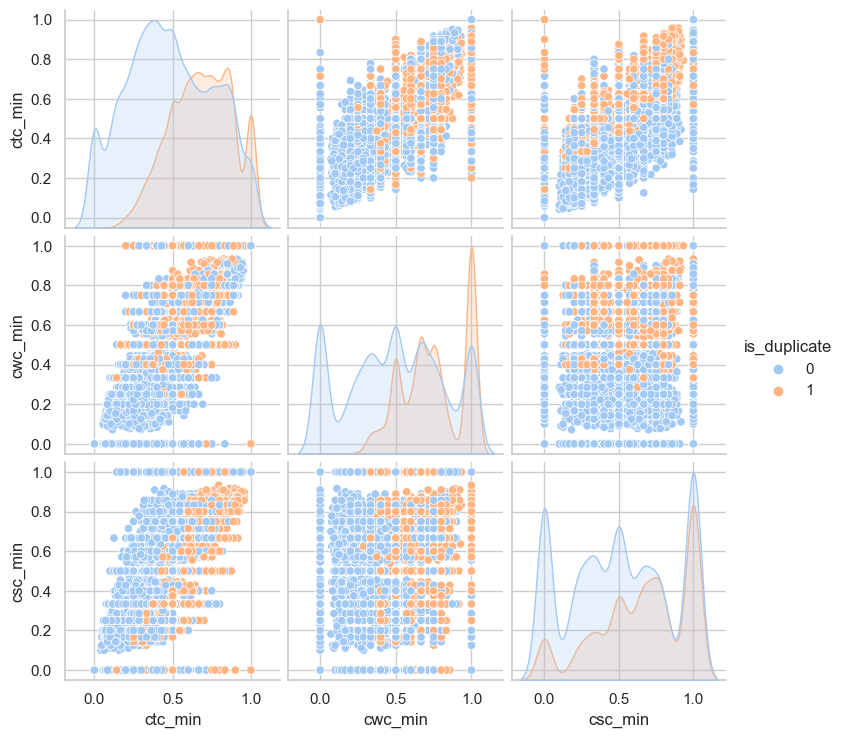

In [81]:
sns.pairplot(new_df[['ctc_min' , 'cwc_min' , 'csc_min', 'is_duplicate']], hue='is_duplicate')

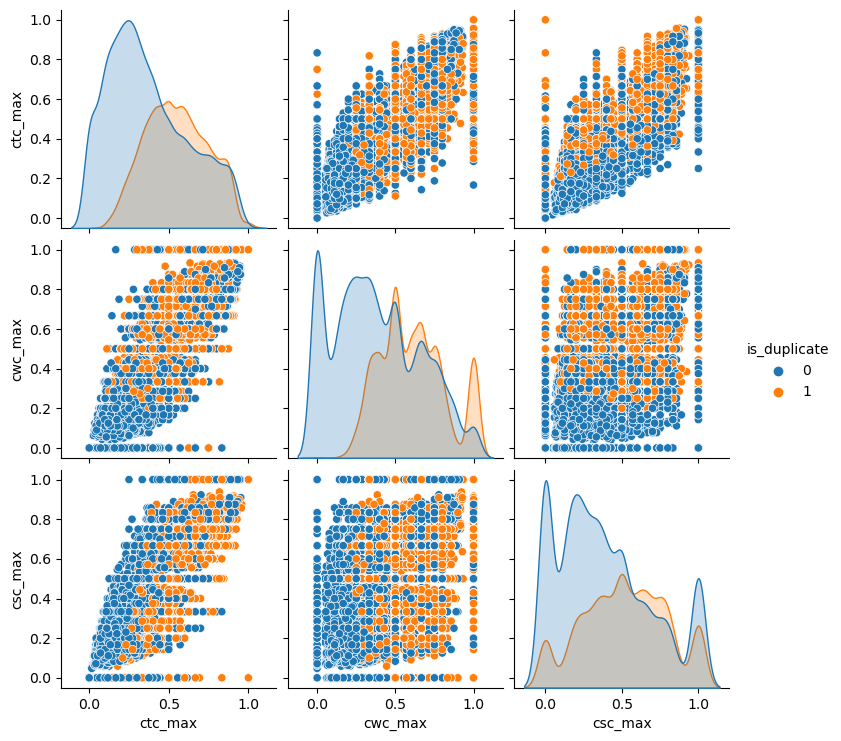

In [46]:
sns.pairplot(new_df[['ctc_max' , 'cwc_max' , 'csc_max', 'is_duplicate']], hue='is_duplicate')

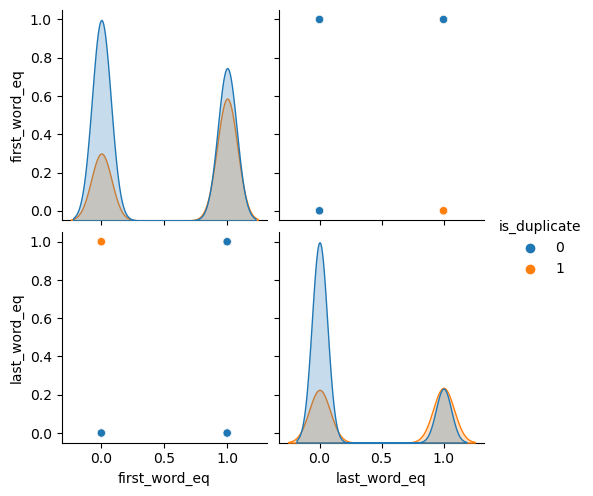

In [47]:
sns.pairplot(new_df[['first_word_eq' , 'last_word_eq' , 'is_duplicate']], hue='is_duplicate')

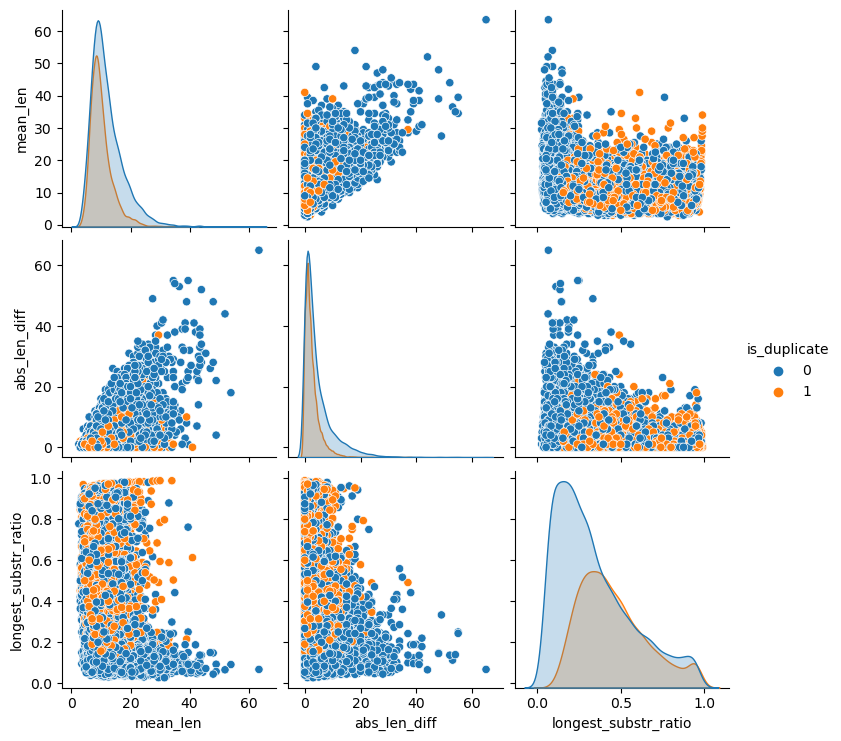

In [48]:
sns.pairplot(new_df[['mean_len' , 'abs_len_diff' , 'longest_substr_ratio', 'is_duplicate']], hue='is_duplicate')

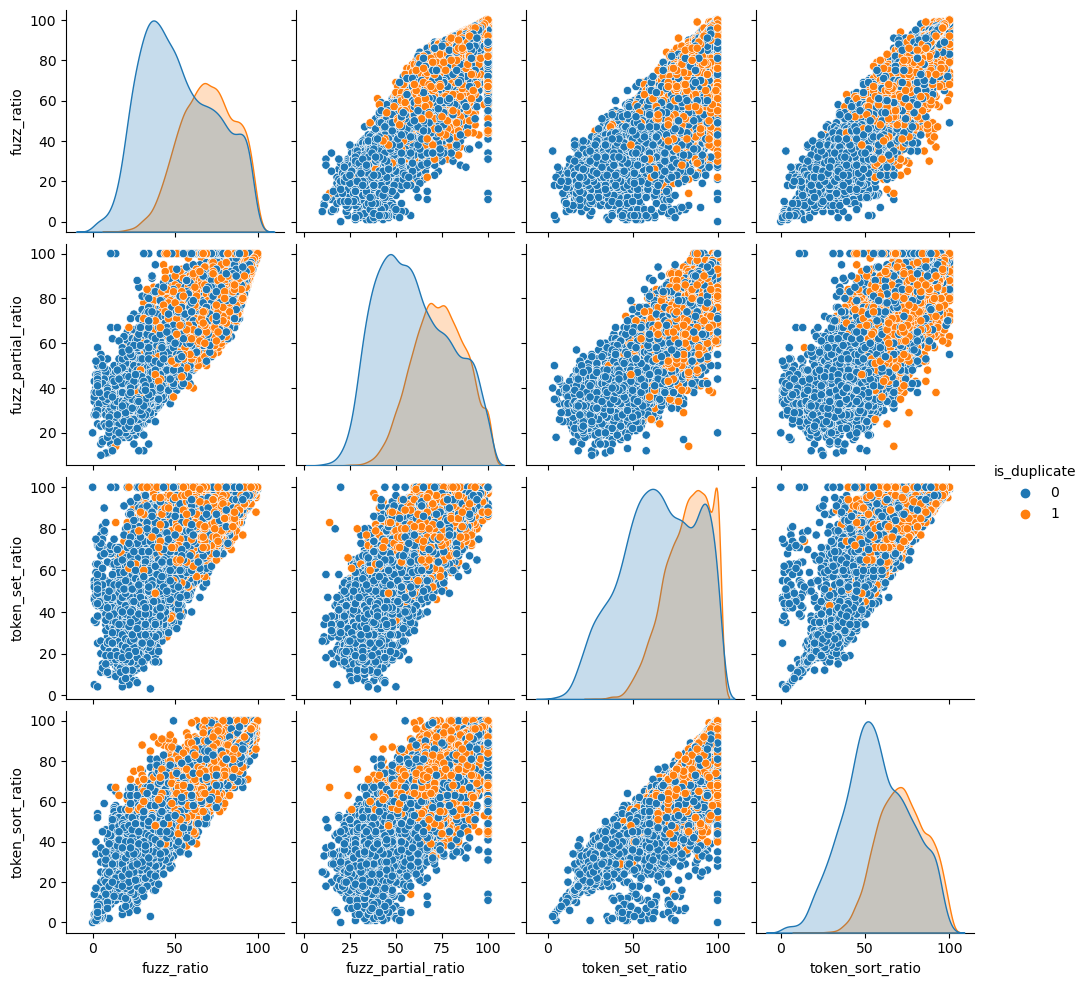

In [49]:
sns.pairplot(new_df[['fuzz_ratio' , 'fuzz_partial_ratio' , 'token_set_ratio', 'token_sort_ratio', 'is_duplicate']], hue='is_duplicate')

The pair plots mentioned above serve to visualize the relationships among the newly introduced advanced features and their impact on the dataset.

In [50]:
ques_df = new_df[['question1' , 'question2']]

In [51]:
final_df = new_df.drop(columns=['id' , 'qid1', 'qid2', 'question1', 'question2'])
print(final_df.shape)

(20000, 23)


In [52]:
questions = list(ques_df['question1']) + list(ques_df['question2'])

In [53]:
cv = CountVectorizer(max_features=3000)

q1_arr , q2_arr = np.vsplit(cv.fit_transform(questions).toarray(),2)

In [54]:
temp1 = pd.DataFrame(q1_arr , index=ques_df.index)
temp2 = pd.DataFrame(q2_arr , index=ques_df.index)
temp_df = pd.concat([temp1 , temp2] , axis=1)
temp_df.shape

(20000, 6000)

`Now the final_df looks like this!`

In [55]:
final_df = pd.concat([final_df, temp_df], axis=1)
print(final_df.shape)
final_df.head()

(20000, 6023)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,common_words,total_words,word_share,cwc_min,cwc_max,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
339499,1,57,41,11,8,6,19,0.32,0.799984,0.666656,...,0,0,0,0,0,0,0,0,0,0
289521,0,51,104,11,23,3,33,0.09,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4665,0,123,122,42,42,18,38,0.47,0.923070,0.923070,...,0,0,0,0,0,0,0,0,0,0
54203,1,44,59,8,10,6,18,0.33,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0
132566,0,53,50,11,13,6,22,0.27,0.749981,0.599988,...,0,0,0,0,0,0,0,0,0,0


In [56]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(final_df.iloc[: , 1:].values , final_df.iloc[: , 0].values , random_state=2 , test_size=0.2)

In [58]:
rf = RandomForestClassifier()

rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

accuracy_score(y_test,y_pred)

0.78025

!pip install xgboost

In [59]:
xgb = XGBClassifier()

xgb.fit(X_train,y_train)
y_pred1 = xgb.predict(X_test)


accuracy_score(y_test,y_pred1)

0.79

In [60]:
# for Random Forest 
confusion_matrix(y_test,y_pred)

array([[2177,  369],
       [ 510,  944]], dtype=int64)

In [61]:
# for XGBoost 
confusion_matrix(y_test,y_pred1)

array([[2150,  396],
       [ 444, 1010]], dtype=int64)

The analysis indicates that the XGBoost model achieves a higher accuracy score compared to the Random Forest model. However, upon examining the confusion matrices, it becomes evident that the Random Forest model exhibits lower False Positive (FP) errors than the XGBoost model. Consequently, despite the higher accuracy of the XGBoost model, the Random Forest model may be preferred due to its lower FP error rate.

In [62]:
def test_common_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [63]:
def test_total_words(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))


In [64]:
def test_fetch_token_features(q1,q2):
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [65]:
def test_fetch_length_features(q1,q2):
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features


In [66]:
def test_fetch_fuzzy_features(q1,q2):
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features


In [67]:
def query_point_creator(q1,q2):
    
    input_query = []
    
    # preprocess
    q1 = preprocess(q1)
    q2 = preprocess(q2)
    
    # fetch basic features
    input_query.append(len(q1))
    input_query.append(len(q2))
    
    input_query.append(len(q1.split(" ")))
    input_query.append(len(q2.split(" ")))
    
    input_query.append(test_common_words(q1,q2))
    input_query.append(test_total_words(q1,q2))
    input_query.append(round(test_common_words(q1,q2)/test_total_words(q1,q2),2))
    
    # fetch token features
    token_features = test_fetch_token_features(q1,q2)
    input_query.extend(token_features)
    
    # fetch length based features
    length_features = test_fetch_length_features(q1,q2)
    input_query.extend(length_features)
    
    # fetch fuzzy features
    fuzzy_features = test_fetch_fuzzy_features(q1,q2)
    input_query.extend(fuzzy_features)
    
    # bow feature for q1
    q1_bow = cv.transform([q1]).toarray()
    
    # bow feature for q2
    q2_bow = cv.transform([q2]).toarray()
    
    
    
    return np.hstack((np.array(input_query).reshape(1,22),q1_bow,q2_bow))


This function `query_point_creator` generates a feature vector for a pair of input questions (`q1` and `q2`). It first preprocesses the questions and extracts basic features like length and word count. Then, it calculates token-based features, length-based features, and fuzzy features. Additionally, it generates Bag-of-Words (BoW) representations for both questions using a pre-trained CountVectorizer (`cv`). Finally, all the extracted features are concatenated along with the BoW representations to form a single feature vector representing the input question pair.

## `Testing The Model`

In [73]:
q1 = 'What is the capital of Pakistan?'
q2 = 'Where is the capital of Pakistan?'
q3 = 'What are the advantages of reading books?'
q4 =  'How does reading improve cognitive abilities?'

In [76]:
rf.predict(query_point_creator(q1,q2)) # Since questions are same the output is 1

array([1], dtype=int64)

In [77]:
rf.predict(query_point_creator(q1,q4)) # Since questions are opposite the output is 0

array([0], dtype=int64)

# `SUMMARY`

The project involves developing a model to identify duplicate pairs of questions. Initial steps include data preprocessing and feature extraction using techniques like CountVectorizer. Advanced features such as tokenization statistics, length-based features, and fuzzy matching scores are incorporated to enhance model performance. Visualizations are employed to analyze the relationship between these features and the target variable. Two models, Random Forest and XGBoost classifiers, are trained and evaluated for accuracy, with XGBoost showing higher performance. However, detailed analysis via confusion matrices suggests that the Random Forest model may be more appropriate due to lower false positive rates. Additionally, it's noted that accuracy can be further increased by incorporating additional features. Finally, a query point creator function is developed for processing input questions for prediction. Overall, the project aims to optimize question matching accuracy through comprehensive feature engineering, model selection, and potential feature augmentation.